In [1]:
# import warnings 
# warnings.filterwarnings("ignore")

# from IPython.display import display, HTML
# from IPython.display import Image
# display(HTML("""
# <style>
# .output {
#     display: flex;
#     align-items: center;
#     text-align: center;
# }
# </style>
# """))

# HTML('''
# <script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>
# <script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
#  } else {
# $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
# ''')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
4,application_1686300280971_0005,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

![pipe](bdccfp_head.png)

<center><h1 style="color:#000000">On Cloud 9: A modern approach to optimizing Aribnb price listing in the post-Covid world</h1></center>

## Imports

In [2]:
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("pandas")
sc.install_pypi_package("display")
sc.install_pypi_package("IPython")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…



  Created wheel for display: filename=display-1.0.0-py3-none-any.whl size=2071 sha256=b45f0ba0b1de87c321172ba4f449c1e65a5aca1152a7b5ba8f32298682bd93d4
  Stored in directory: /mnt/tmp/pip-ephem-wheel-cache-zswwyeji/wheels/28/ec/cc/8f044b2a2dd8b45ccfc45317e7e9aa4e544e6c0b2a737330ae
Successfully built display






In [3]:
sc.install_pypi_package("boto3")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt
import boto3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, mean, avg, lag, to_date
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import corr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<h1 style="color:#000000">I. Executive Summary</h1>

Following the lightening of travel restrictions due to Covid, there is a notable increase in the number of tourists looking for private spaces like Airbnb. This increase represents a new regime in how Airbnb listing prices are determined and Airbnb owners are trying to figure out, or in the case of this report, forecast how their properties should be priced in these times in order to achieve maximum profitability. For this project, we perform a time series forecast of listing prices for the top tourist destinations in the US in Airbnb's available dataset. We do this using two models, Linear Regression, and Random Forest. Our forecast results show that Linear Regression is the better of the two models with an average mean absolute percentage error (MAPE) of 1.14%. To further improve this study, we suggest that other models be used, especially Gradient Boosting methods that are more frequently used in time series forecasting. Another recommendation is to extend the scope of this project to other countries outside the US.

<h1 style="color:#000000">II. Problem Statement</h1>

In this report we want to answer the question:

How can we use cloud computing and machine learning to help hosts set a better price given certain times for US properties listed on Airbnb?

<h1 style="color:#000000">III. Motivation</h1>

As travel restrictions start to lighten after the long Covid pandemic, we also notice an increase in the number of people who want to travel. This effectively results in an increase in the number of people looking for accommodations. But habits developed from the pandemic still linger as we see a shift in the preference of tourists from hotels with public spaces to more private spaces like Airbnb's. This growth represents a new regime in how Airbnb listing prices are determined and Airbnb owners are trying to figure out, or in the case of this report, forecast how their properties should be priced in these times in order to achieve maximum profitability.

<h1 style="color:#000000">IV. Data Source</h1>

**Database description**

Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. They work towards a vision where data and information empower communities to understand, decide and control the role of renting residential homes to tourists.

Filepath: The data is stored in an S3 bucket, specific filepath is s3a://bdcc-rgalenton-project-2023/e-BKUGKQ5SGVC7UX5CP9LILNBP1/

**Database Summary:**

- The database comprises several datasets providing comprehensive details about Airbnb listings across various cities globally. It includes data about listings, hosts, reviews, and calendar availability.

**Original Data Source**

ODS description 
- This database contains information about Airbnb listings, calendars, reviews and various attributes, including prices property details, and host information.

Relevant links:
http://insideairbnb.com/get-the-data

<h3><u>Calendar data</u></h3>

- This dataset provides availability information of listings for various dates. It includes the listing ID, the date, and whether the listing is available on that date.

<br />

<center><h3 style="color:#000000"><u>Raw Data Description</u></h3></center>


|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Category</center>|<center>Description</center>
|:---|:---|:---|:---|
|listing_id|integer|ordinal|Unique ID of the listing|
|date|timestamp|nominal|Date on the listing's calendar|
|availability|string|categorical|Whether listing is available or not|
|price|integer|nominal|Price to stay in the listing|
|adjusted_price|integer|nominal|Price to stay in the listing(?)|
|minimum_nights|integer|nominal|Minimum nights one can stay in the listing|
|maximum_nights|integer|nominal|Maximum nights one can stay in the listing|
<center><i>Table 1. Inside Airbnb Calendar Dataset</i></center>

# Preprocessing

In [5]:
# # Webscraping new 2023 data
# import boto3
# import requests
# from bs4 import BeautifulSoup

# # The url of the page you want to scrape
# url = 'http://insideairbnb.com/get-the-data.html'

# # Send a request to the website
# r = requests.get(url)

# # Parse the HTML content of the page with BeautifulSoup
# soup = BeautifulSoup(r.text, 'html.parser')

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify your bucket name
# bucket_name = 'bdcc-rgalenton-project-2023'

# # Specify your folder name
# folder_name = 'e-BKUGKQ5SGVC7UX5CP9LILNBP1/'

# # Initialize a counter for the total file size
# total_file_size = 0

# # Find all 'a' tags (which define hyperlinks) in the HTML
# for link in soup.find_all('a'):
    
#     href = link.get('href')
    
#     # If href contains a csv file link
#     if href and '.csv.gz' in href:
#         file_url = href
        
#         # Get the state, city and date from the href
#         parts = href.split('/')
#         state_name = parts[-4]
#         city_name = parts[-3]
#         date = parts[-2]
        
#         # Send a request to download the file
#         file_r = requests.get(file_url, stream=True)
        
#         # Add the file size to the total
#         total_file_size += int(file_r.headers.get('Content-Length', 0))
        
#         # Get the file name and append the state name, city name and date
#         file_name = state_name + "_" + city_name + "_" + date + "_" + file_url.split('/')[-1]
        
#         # Upload file to S3 in the specified folder
#         s3.upload_fileobj(file_r.raw, bucket_name, folder_name + file_name)

#         print(f"{file_name} downloaded and uploaded to S3.")

# # Convert the total file size to GB
# total_file_size_gb = total_file_size / (1024 * 1024 * 1024)
# print(f"Total file size downloaded and uploaded to S3: {total_file_size_gb:.2f} GB")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# S3 bucket
bucket_name = 'bdcc-rgalenton-project-2023'

# List of states
states = ['co', 'ca', 'dc', 'hi', 'ny']

# Dictionary to store the DataFrames for each state
state_dfs = {}

# Create a Boto3 session
session = boto3.Session()

# Retrieve the S3 client
s3_client = session.client('s3')

for state in states:
    # Folder path for the state
    folder_path = f'e-BKUGKQ5SGVC7UX5CP9LILNBP1/{state}/'

    # List all calendar.csv.gz files in the specified S3 bucket and folder path
    s3_objects = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)

    # Extract the file paths of calendar.csv.gz files
    file_paths = [obj['Key'] for obj in s3_objects['Contents'] if obj['Key'].endswith('calendar.csv.gz')]

    # Read all calendar.csv.gz files into a single DataFrame
    df_calendar = spark.read.csv(["s3a://" + bucket_name + "/" + file_path for file_path in file_paths], header=True)

    # Data transformations
    df_calendar = df_calendar.withColumn('price', regexp_replace(col('price'), '[$,]', ''))
    df_calendar = df_calendar.withColumn('price', df_calendar['price'].cast('float'))
    df_calendar = df_calendar.withColumn('date', df_calendar['date'].cast('date'))

    # Store DataFrame in the dictionary
    state_dfs[state] = df_calendar

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
state_dfs['ca'].show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+---------+-----+--------------+--------------+--------------+
|listing_id|      date|available|price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+-----+--------------+--------------+--------------+
|    183319|2022-09-10|        f|152.0|       $152.00|            30|            90|
|     51307|2022-09-10|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-11|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-12|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-13|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-14|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-15|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-16|        f| 75.0|        $75.00|            30|           365|
|     51307|2022-09-17|        f| 75.0|        $75.00|           

In [8]:
def preprocess_df(df):
    # Compute mean price
    mean_price = df.select(mean(df['price'])).collect()[0][0]

    # Fill nulls with mean price
    df = df.na.fill(mean_price, subset=['price'])

    # Perform the aggregation
    prices_df = df.groupBy('date').agg(avg('price').alias('avg_price'))

    return prices_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Apply the function to each DataFrame in the dictionary
state_prices_dfs = {state: preprocess_df(df) for state, df in state_dfs.items()}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
state_prices_dfs['ca'].show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+
|      date|         avg_price|
+----------+------------------+
|2022-11-29| 294.3406545145183|
|2019-11-01|217.85586006769688|
|2022-11-21| 304.6486365183602|
|2023-06-23| 341.9485085348035|
|2020-03-07|221.02864045051214|
|2022-10-19| 293.6542982310283|
|2022-12-20|298.90895113609565|
|2023-01-01| 324.0361685298929|
|2020-05-08|220.62553324021684|
|2023-08-28|316.97189382364525|
+----------+------------------+
only showing top 10 rows

<h1 style="color:#000000">V. Data Exploration</h1>



In [11]:
state_dfs['hi'].printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- listing_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- available: string (nullable = true)
 |-- price: float (nullable = true)
 |-- adjusted_price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- maximum_nights: string (nullable = true)

In [12]:
state_dfs['hi'].describe(['price', 'minimum_nights', 'maximum_nights']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+--------------------+
|summary|             price|   minimum_nights|      maximum_nights|
+-------+------------------+-----------------+--------------------+
|  count|         112595666|        112588134|           112588134|
|   mean|424.49090445452845|7.657018527369856|    87432.5981839969|
| stddev|1115.6704265810752|19.50190465850712|1.3648498446844706E7|
|    min|               0.0|                1|                   1|
|    max|          100000.0|               99|                9999|
+-------+------------------+-----------------+--------------------+

## VI. Methodology

![pipe](bdccfp_pipe.png)

<center><i>Figure 1. Methodology Pipeline</i></center>

We followed the following steps in our methodology:

1. **Data Collection**: We started by scraping the available data from the Inside Airbnb website. Due to limitations, we only obtained data for the recent year. However, with permission from Prof Alis, we were granted access to the Jojie dataset, which spans from 2015 to 2021.

2. **Data Cleaning and Pre-processing**: As the data was initially read as strings by Spark, we performed cleaning and pre-processing steps to ensure data quality. This involved handling missing values, converting data types, and applying appropriate transformations.

3. **Exploratory Data Analysis (EDA)**: To gain insights and understand the data, we conducted EDA. We analyzed the distribution of prices, examined the availability of listings over time, and identified any patterns or trends.

4. **Time Series Forecasting**: Considering the seasonality in the data, we plotted the autocorrelation of the time series. This helped us determine the appropriate seasonality to consider in our forecasting models. We employed three models for time series forecasting: Linear Regression, Random Forest, and LightGBM.

5. **Model Evaluation**: We evaluated the performance of each forecasting model using various metrics, including Root Mean Squared Error (RMSE), Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). By comparing these metrics, we identified the model that exhibited the best performance.

By following this methodology, we aimed to develop accurate and reliable forecasts for the Airbnb price listings.


<h1 style="color:#000000">VII. Main Body</h1>

<h2 style="color:#000000">Auto-correlation plot</h2>

In [22]:

## Create the time series dataframe
filecal = 's3://bdcc-rgalenton-project-2023/e-BKUGKQ5SGVC7UX5CP9LILNBP1/*calendar.csv.gz'
df_calendar = (spark.read.csv(filecal,header=True))
df_calendar = df_calendar.withColumn('price', regexp_replace(col('price'), '[$,]', ''))
df_calendar = df_calendar.withColumn('adjusted_price', regexp_replace(col('adjusted_price'), '[$,]', ''))
df_calendar = df_calendar.withColumn('price', df_calendar['price'].cast('float'))
df_calendar = df_calendar.withColumn('adjusted_price', df_calendar['adjusted_price'].cast('float'))
df_calendar = df_calendar.withColumnRenamed('date', 'date')
df1 = df_calendar.groupBy('date').agg(
    {
        'price': 'avg'
    }
).withColumn('price', col('avg(price)')).drop('avg(price)')

# Removing zeros
df1 = df1.filter(col('price') != 0)

spark_dff = df1 # assign the spark dataframe to spark_dff

## Add a lagged column 'value_lag'
# Specify the number of time lags
lags = 25

# Create lagged columns
for n in range(1, lags + 1):
    windowSpec = Window.orderBy('date').rowsBetween(-n, -n)
    spark_dff = spark_dff.withColumn(f'price_lag{n}',lag('price',n).over(windowSpec))

# Assemble the lagged columns and the value column into a vector column
colnames = spark_dff.columns
colnames.pop(0)

assembler = VectorAssembler(inputCols=colnames, outputCol='features')
df = assembler.transform(spark_dff)

## Calculate the Pearson correlations 'by hand'
corrs = []
for n in range(1, lags+1):
    corrs.append(df.select(corr('price', f'price_lag{n}')).head()[0])

## Print the result
if lags > 24:
    tickmarks = range(0, lags, 7)
else:
    tickmarks = range(0, lags)
    
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(range(1, lags+1), corrs)

plt.title('Discovering Connections: How AirBnB Price Listings Influence Each Other Over Time')
plt.xlabel('time lag [days]')
plt.ylabel('Pearson Correlation')
plt.axvline(7, color='red', linestyle='dotted')
plt.axvline(14, color='red', linestyle='dotted')
plt.axvline(21, color='red', linestyle='dotted')
plt.xticks(tickmarks)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

![pipe](autcorr_bdcc.png)

<center><i>Figure 2. Auto-correlation Plot</i></center>

<h2 style="color:#000000">Time Series Analysis</h2>

<h2 style="color:#000000">TS Linear Regression</h2>

In [14]:
# Function for Linear Regression
def model_lr(state_prices_df, state, show_actual=True):
    # Prepare data
    lags = 7
    for n in range(1, lags + 1):
        windowSpec = Window.orderBy('date').rowsBetween(-n, -n)
        state_prices_df = state_prices_df.withColumn(f'avg_price_lag{n}', lag('avg_price', n).over(windowSpec))
    df = state_prices_df.dropna()
    va = VectorAssembler(inputCols=df.columns[2:], outputCol='features')
    va_df = va.transform(df)
    va_df = va_df.select(['date', 'features', 'avg_price'])

    # Temporal split of data
    sorted_df = va_df.sort('date')
    train_data = sorted_df.filter(sorted_df['date'] < '2022-01-01')
    test_data = sorted_df.filter((sorted_df['date'] >= '2022-01-01') & (sorted_df['date'] <= '2025-12-31'))

    # Linear regression
    lr = LinearRegression(featuresCol='features', labelCol='avg_price')
    lr_model = lr.fit(train_data)
    test_data_with_date = test_data.select("date", "features", "avg_price")
    predictions = lr_model.transform(test_data_with_date)

    # Plot
    predictions = predictions.withColumn('date', to_date('date'))
    predictions = predictions.sort('date')
    predictions_pd = predictions.toPandas()

    plt.clf()
    plt.figure(figsize=(14, 7))
    if show_actual:
        plt.plot_date(predictions_pd['date'], predictions_pd['avg_price'], 'b-', label='Actual')
    plt.plot_date(predictions_pd['date'], predictions_pd['prediction'], 'r-', label='LR_Predicted')
    plt.title('Time series of prices for ' + state.upper())
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### California

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

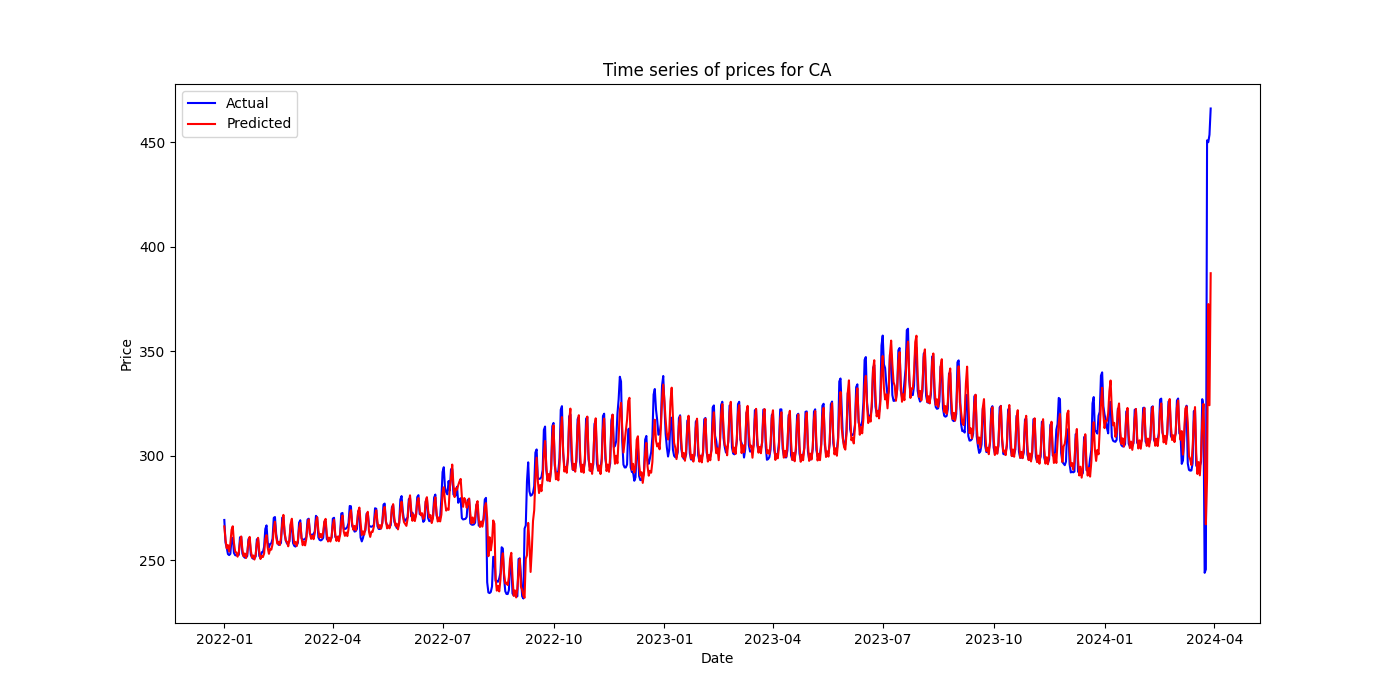

In [ ]:
model_lr(state_prices_dfs['ca'], 'ca')
%matplot plt

<center><i>Figure 3. Linear Regression Time Series Plot for California</i></center>

### DC

In [ ]:
dc_lr = model_lr(state_prices_dfs['dc'], 'dc')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

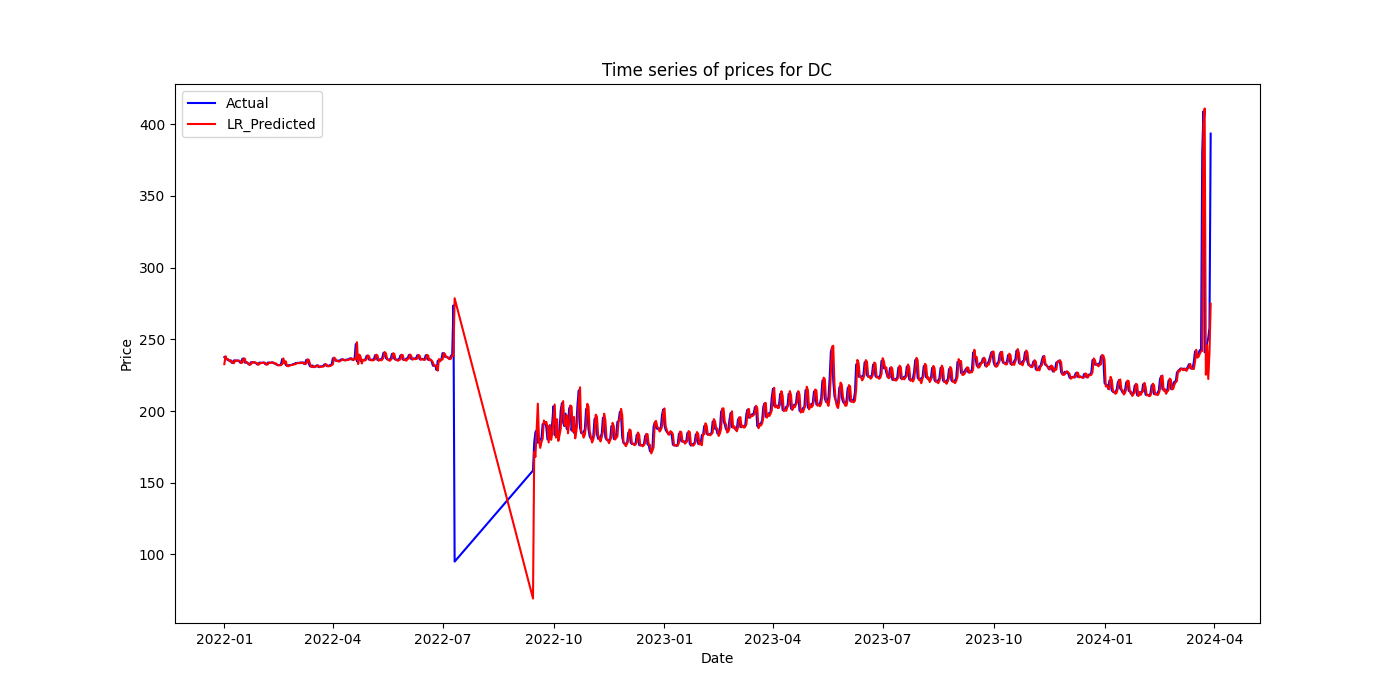

In [ ]:
dc_lr
%matplot plt

<center><i>Figure 4. Linear Regression Time Series Plot for Washington DC</i></center>

### Colorado

In [ ]:
co_lr = model_lr(state_prices_dfs['co'], 'co')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

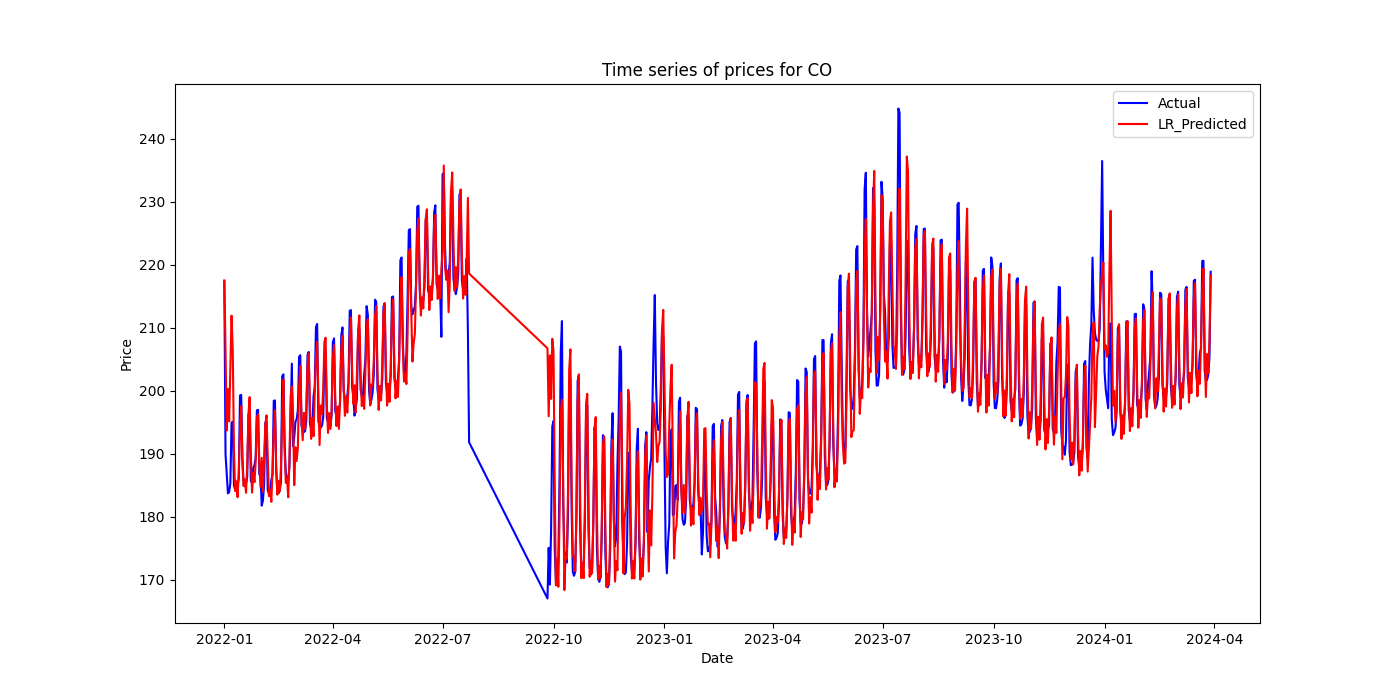

In [ ]:
co_lr
%matplot plt

<center><i>Figure 5. Linear Regression Time Series Plot for Colorado</i></center>

### Hawaii

In [ ]:
hi_lr = model_lr(state_prices_dfs['hi'], 'hi')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

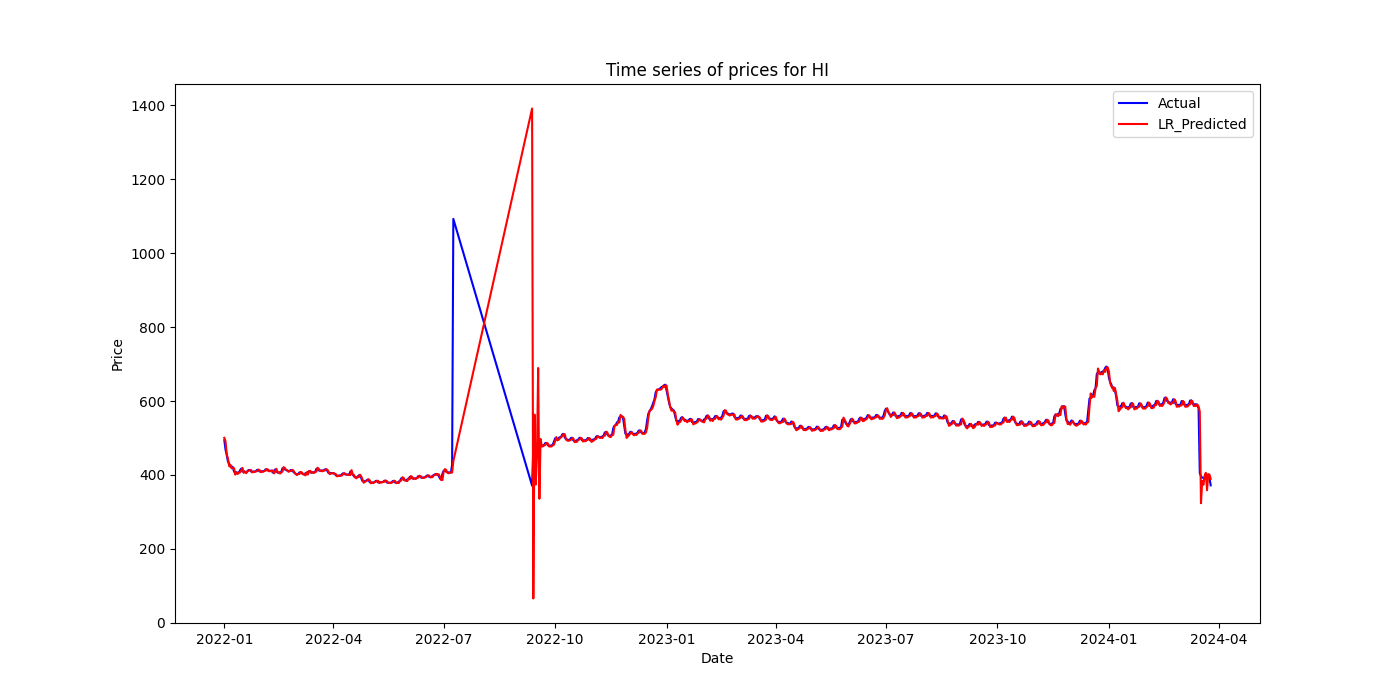

In [ ]:
hi_lr
%matplot plt

<center><i>Figure 6. Linear Regression Time Series Plot for Hawaii</i></center>

### New York

In [ ]:
ny_lr = model_lr(state_prices_dfs['ny'], 'ny')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

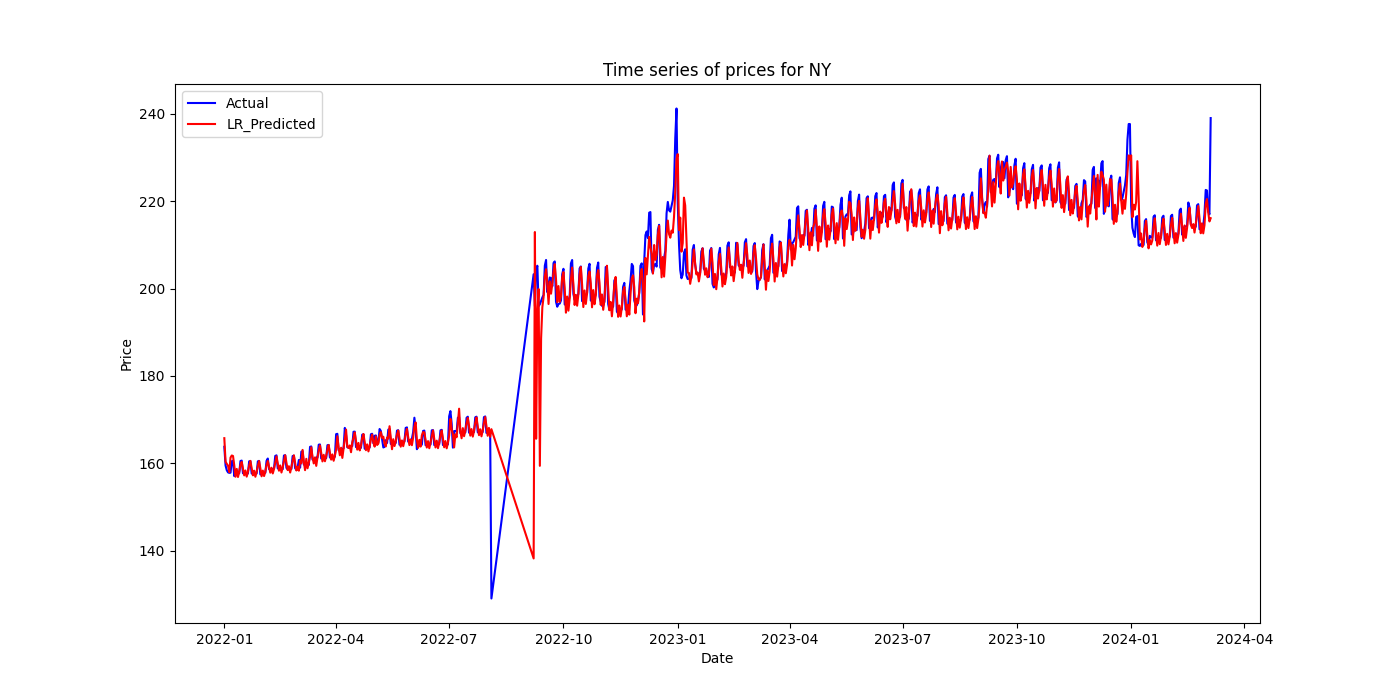

In [ ]:
ny_lr
%matplot plt

<center><i>Figure 7. Linear Regression Time Series Plot for New York</i></center>

## Run First 3 States

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, regexp_replace, col
from pyspark.sql.window import Window
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import (VectorAssembler, StringIndexer, OneHotEncoder, 
                                Tokenizer, CountVectorizer)
import matplotlib.pyplot as plt
import pandas as pd
states = ['co', 'ca', 'dc']  # replace with actual state names
models = {}
performance = {}
predictions = {}
actuals = {}

for state in states:
    filepath = f's3://bdcc-rgalenton-project-2023/e-BKUGKQ5SGVC7UX5CP9LILNBP1/*{state}_*_data_calendar.csv.gz'
    df_calendar = (spark.read.csv(filepath,header=True))
    df_calendar = df_calendar.withColumn('price', regexp_replace(col('price'), '[$,]', ''))
    df_calendar = df_calendar.withColumn('adjusted_price', regexp_replace(col('adjusted_price'), '[$,]', ''))
    df_calendar = df_calendar.withColumn('price', df_calendar['price'].cast('float'))
    df_calendar = df_calendar.withColumn('adjusted_price', df_calendar['adjusted_price'].cast('float'))
    df_calendar = df_calendar.withColumn('date', df_calendar['date'].cast('date'))
    from pyspark.sql.functions import mean
    from pyspark.sql.functions import avg
    # Compute mean price
    mean_price = df_calendar.select(mean(df_calendar['price'])).collect()[0][0]

    # Fill nulls with mean price
    df_calendar = df_calendar.na.fill(mean_price, subset=['price'])

    # Perform the aggregation
    prices_df = df_calendar.groupBy('date').agg(avg('price').alias('avg_price'))
    lags = 7

    # Create lagged columns
    for n in range(1, lags + 1):
        windowSpec = Window.orderBy('date').rowsBetween(-n, -n)
        prices_df = prices_df.withColumn(f'avg_price_lag{n}', lag('avg_price',n).over(windowSpec))

    df = prices_df.dropna()  # instead of excluding first 'lags' rows, we drop rows with nulls
    va = VectorAssembler(inputCols=df.columns[2:], outputCol='features')  # considering 'date' and 'avg_price' are first two columns
    va_df = va.transform(df)
    va_df = va_df.select(['date', 'features', 'avg_price'])
    train_data, test_data = va_df.randomSplit([0.8, 0.2], seed=123)
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    lr = LinearRegression(featuresCol='features', labelCol='avg_price')
    lr_model = lr.fit(train_data)
    models[state] = lr_model

    test_data_with_date = test_data.select("date", "features", "avg_price")
    pred = lr_model.transform(test_data_with_date)
    predictions[state] = pred.select('prediction').toPandas()
    actuals[state] = pred.select('avg_price').toPandas()

    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="rmse")
    rmse = evaluator.evaluate(pred)
    performance[state] = rmse

# Plotting time series for each state
plt.clf()
plt.figure(figsize=(12, 6))
for state in states:
    plt.plot(predictions[state], label=f'{state} predicted')
    plt.plot(actuals[state], label=f'{state} actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

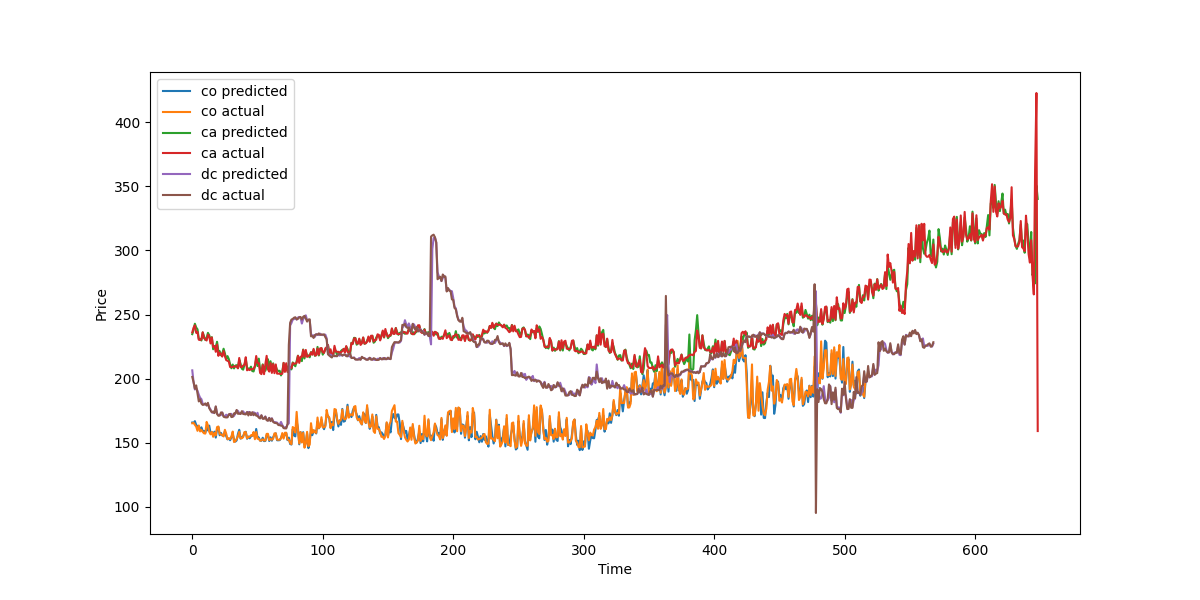

In [ ]:
plt.clf()
plt.figure(figsize=(12, 6))
for state in states:
    plt.plot(predictions[state], label=f'{state} predicted')
    plt.plot(actuals[state], label=f'{state} actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
%matplot plt

<center><i>Figure 8. Linear Regression Time Series Plot for 3 States</i></center>

In [ ]:
for state in performance:
    print(f"The RMSE for {state} is: {performance[state]}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The RMSE for co is: 3.4039698229222966
The RMSE for ca is: 9.024639969189689
The RMSE for dc is: 9.068321195914642

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id, abs, col

performance = {}

for state in states:
    pred = predictions[state]
    # Convert back to DataFrame from pandas for evaluator
    pred = spark.createDataFrame(pred)
    actual = actuals[state]
    actual = spark.createDataFrame(actual)

    # Adding 'avg_price' column to 'pred' dataframe from 'actual' dataframe
    pred = pred.withColumn("id", monotonically_increasing_id())
    actual = actual.withColumn("id", monotonically_increasing_id())
    pred = pred.join(actual, "id", "outer").drop("id")

    # Calculating RMSE
    evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="rmse")
    rmse = evaluator_rmse.evaluate(pred)

    # Calculating MSE
    evaluator_mse = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mse")
    mse = evaluator_mse.evaluate(pred)

    # Calculating MAE
    evaluator_mae = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mae")
    mae = evaluator_mae.evaluate(pred)
    
    # Calculating MAPE
    mape = pred.withColumn('MAPE', (abs((col('avg_price') - col('prediction')) / col('avg_price')) * 100)).select('MAPE').agg({'MAPE': 'mean'}).collect()[0][0]

    performance[state] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'MAPE': mape}

# print performance metrics
for state in states:
    print(f"Performance for {state}:")
    print(f"RMSE: {performance[state]['RMSE']}")
    print(f"MSE: {performance[state]['MSE']}")
    print(f"MAE: {performance[state]['MAE']}")
    print(f"MAPE: {performance[state]['MAPE']}")
    print("-----------------------------")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Performance for co:
RMSE: 3.4039698229222988
MSE: 11.587010555365666
MAE: 2.4821469851850355
MAPE: 1.416004006925661
-----------------------------
Performance for ca:
RMSE: 9.024639969189687
MSE: 81.44412657349606
MAE: 2.5724368091421677
MAPE: 1.0607781473567996
-----------------------------
Performance for dc:
RMSE: 9.068321195914644
MSE: 82.23444931227482
MAE: 1.9712526271212216
MAPE: 1.0816086533714195
-----------------------------

# All 5 states

In [ ]:
import boto3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, mean, avg, lag, to_date
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder.getOrCreate()

# S3 bucket
bucket_name = 'bdcc-rgalenton-project-2023'

# List of states
states = ['co', 'ca', 'dc', 'hi', 'ny']

# List to store predictions and actuals for each state
predictions_lr = {}
predictions_rf = {}
actuals = {}

for state in states:
    # Folder path for the state
    folder_path = f'e-BKUGKQ5SGVC7UX5CP9LILNBP1/{state}/'

    # Create a Boto3 session
    session = boto3.Session()

    # Retrieve the S3 client
    s3_client = session.client('s3')

    # List all calendar.csv.gz files in the specified S3 bucket and folder path
    s3_objects = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)

    # Extract the file paths of calendar.csv.gz files
    file_paths = [obj['Key'] for obj in s3_objects['Contents'] if obj['Key'].endswith('calendar.csv.gz')]

    # Read all calendar.csv.gz files into a single DataFrame
    dfs = []
    for file_path in file_paths:
        df = spark.read.csv(f's3a://{bucket_name}/{file_path}', header=True)
        dfs.append(df)

    # Filter and select the required columns
    selected_columns = ['listing_id', 'date', 'price']
    dfs_selected = [df.select(selected_columns) for df in dfs]

    # Perform the union
    df_calendar = dfs_selected[0]
    for i in range(1, len(dfs_selected)):
        df_calendar = df_calendar.union(dfs_selected[i])

    # Data transformations
    df_calendar = df_calendar.withColumn('price', regexp_replace(col('price'), '[$,]', ''))
    df_calendar = df_calendar.withColumn('price', df_calendar['price'].cast('float'))
    df_calendar = df_calendar.withColumn('date', to_date(df_calendar['date'], 'yyyy-MM-dd'))

    # Compute mean price
    mean_price = df_calendar.select(mean(df_calendar['price'])).collect()[0][0]

    # Fill nulls with mean price
    df_calendar = df_calendar.na.fill(mean_price, subset=['price'])

    # Perform the aggregation
    prices_df = df_calendar.groupBy('date').agg(avg('price').alias('avg_price'))

    # Create lagged columns
    lags = 7
    for n in range(1, lags + 1):
        windowSpec = Window.orderBy('date').rowsBetween(-n, -n)
        prices_df = prices_df.withColumn(f'avg_price_lag{n}', lag('avg_price', n).over(windowSpec))

    df = prices_df.dropna()  # instead of excluding first 'lags' rows, we drop rows with nulls
    va = VectorAssembler(inputCols=df.columns[2:], outputCol='features')  # considering 'date' and 'avg_price' are first two columns
    va_df = va.transform(df)
    va_df = va_df.select(['date', 'features', 'avg_price'])
    train_data, test_data = va_df.randomSplit([0.8, 0.2], seed=123)
    train_data = train_data.dropna()
    test_data = test_data.dropna()

    # Linear Regression
    lr = LinearRegression(featuresCol='features', labelCol='avg_price')
    lr_model = lr.fit(train_data)
    test_data_with_date = test_data.select("date", "features", "avg_price")
    pred_lr = lr_model.transform(test_data_with_date)
    predictions_lr[state] = pred_lr.select('prediction').toPandas()

    # Random Forest Regression
    rf = RandomForestRegressor(featuresCol='features', labelCol='avg_price', numTrees=100)
    rf_model = rf.fit(train_data)
    pred_rf = rf_model.transform(test_data_with_date)
    predictions_rf[state] = pred_rf.select('prediction').toPandas()

    actuals[state] = pred_lr.select('avg_price').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Initialization
plt.clf()
plt.figure(figsize=(14, 7))

# Dictionary to store dates for each state
dates_dict = {}

# Loop over states
for state in states:
    # Extract dates and convert to pandas
    dates_dict[state] = pred_lr.select('date').toPandas()

    # Plotting
    plt.plot_date(dates_dict[state]['date'], actuals[state]['avg_price'], label=f'Actual {state}')
    plt.plot_date(dates_dict[state]['date'], predictions_lr[state]['prediction'], label=f'LR Predicted {state}')
    plt.plot_date(dates_dict[state]['date'], predictions_rf[state]['prediction'], label=f'RF Predicted {state}')

# Title and labels
plt.title('Time series of prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Column 'date' does not exist. Did you mean one of the following? [avg_price, prediction];
'Project ['date]
+- Project [prediction#39066, avg_price#39068]
   +- Project [coalesce(id#39070L, id#39073L) AS id#39076L, prediction#39066, avg_price#39068]
      +- Join FullOuter, (id#39070L = id#39073L)
         :- Project [prediction#39066, monotonically_increasing_id() AS id#39070L]
         :  +- LogicalRDD [prediction#39066], false
         +- Project [avg_price#39068, monotonically_increasing_id() AS id#39073L]
            +- LogicalRDD [avg_price#39068], false

Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1685667388090_0009/container_1685667388090_0009_01_000001/pyspark.zip/pyspark/sql/dataframe.py", line 2024, in select
    jdf = self._jdf.select(self._jcols(*cols))
  File "/mnt1/yarn/usercache/livy/appcache/application_1685667388090_0009/container_1685667388090_0009_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

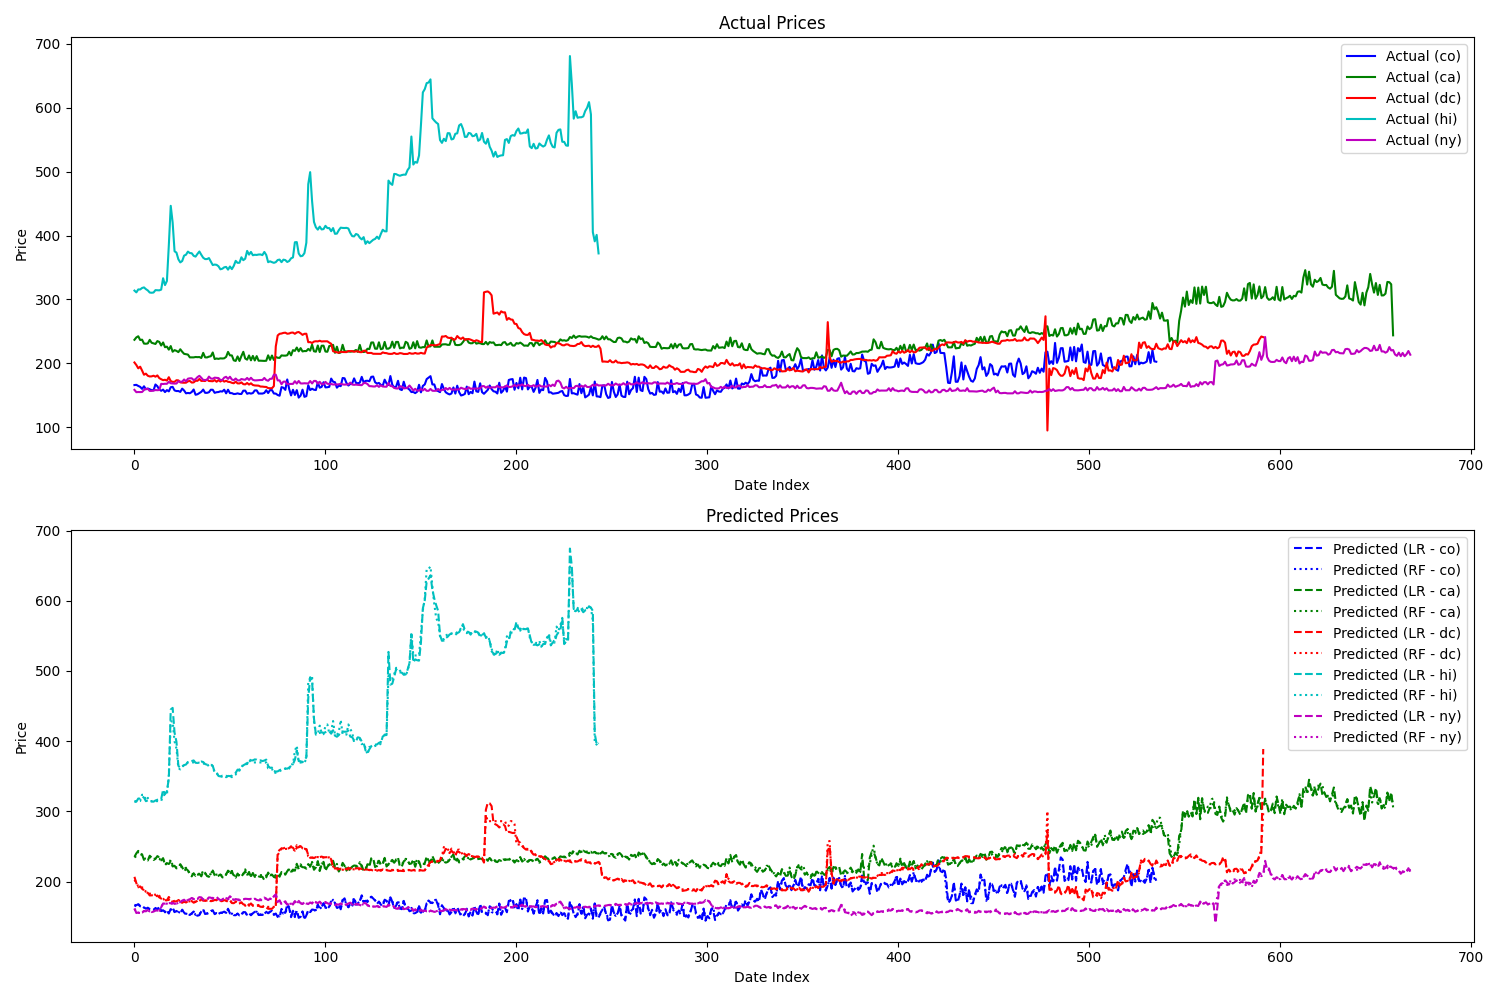

In [ ]:
plt.clf()
# Create the figure and the axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Iterate over states
for i, state in enumerate(states):

    # Define the color and style for each state
    color = ['b', 'g', 'r', 'c', 'm'][i]
    style_actual = color + '-'
    style_lr = color + '--'
    style_rf = color + ':'

    # Plot actual values on first subplot
    ax[0].plot(actuals[state], style_actual, label=f'Actual ({state})')

    # Plot predicted values from Linear Regression model on second subplot
    ax[1].plot(predictions_lr[state], style_lr, label=f'Predicted (LR - {state})')

    # Plot predicted values from Random Forest model on second subplot
    ax[1].plot(predictions_rf[state], style_rf, label=f'Predicted (RF - {state})')

# Set titles, labels and legends
ax[0].set_title('Actual Prices')
ax[0].set_xlabel('Date Index')
ax[0].set_ylabel('Price')
ax[0].legend(loc='best')

ax[1].set_title('Predicted Prices')
ax[1].set_xlabel('Date Index')
ax[1].set_ylabel('Price')
ax[1].legend(loc='best')

# Adjust the layout and show the plot
plt.tight_layout()
%matplot plt

<center><i>Figure 9. Linear Regression Time Series Plot for All 5 States</i></center>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

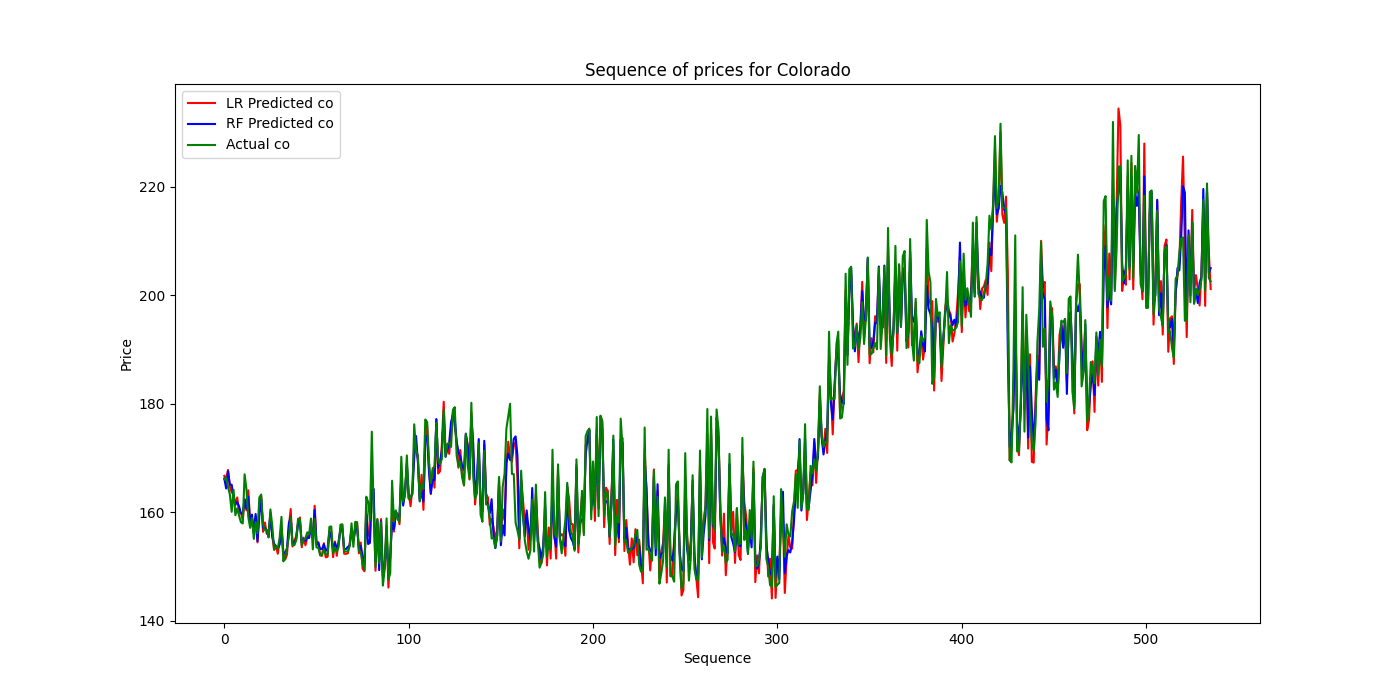

In [ ]:
plt.clf()
states = ['co']
for state in states:
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_lr[state]['prediction'], 'r-', label=f'LR Predicted {state}')
    plt.plot(predictions_rf[state]['prediction'], 'b-', label=f'RF Predicted {state}')
    plt.plot(actuals[state]['avg_price'], 'g-', label=f'Actual {state}')
    plt.title(f'Sequence of prices for Colorado')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.savefig('colorado_5state.png')
%matplot plt

<center><i>Figure 10. Random Forest-Linear Regression Time Series Plot for Colorado</i></center>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

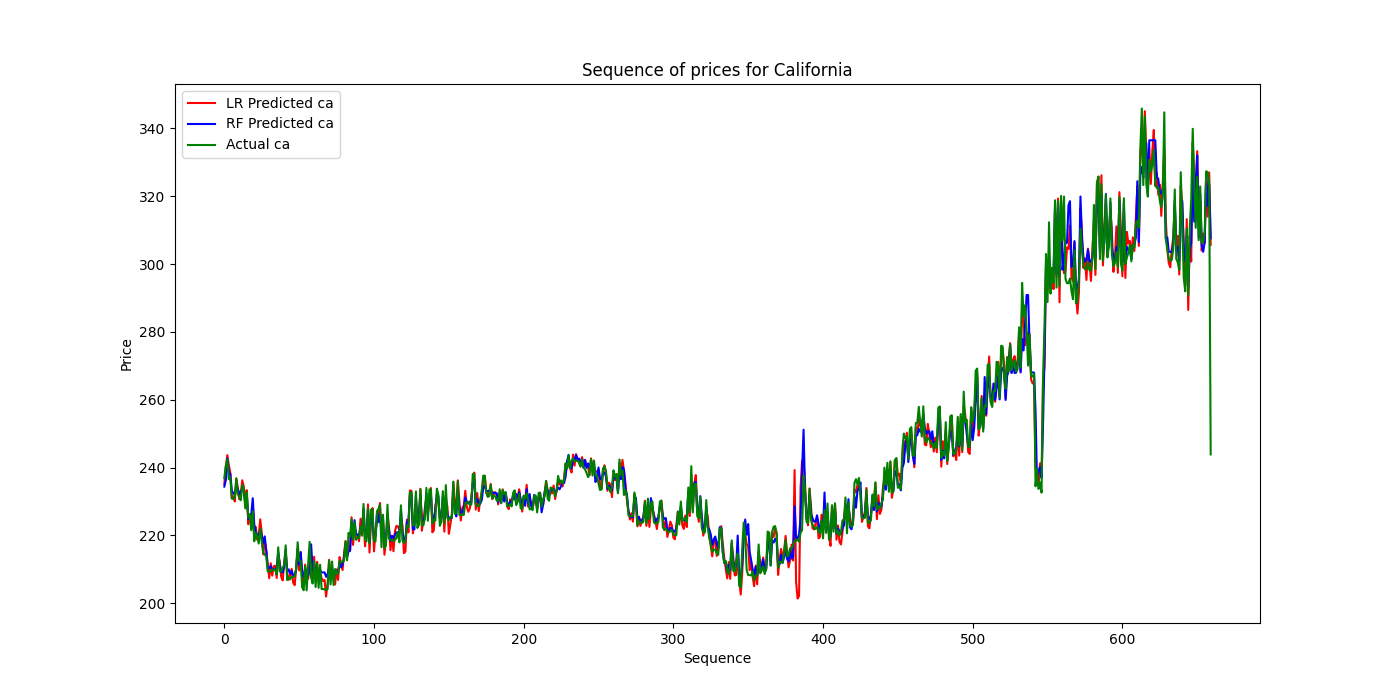

In [ ]:
plt.clf()
states = ['ca']
for state in states:
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_lr[state]['prediction'], 'r-', label=f'LR Predicted {state}')
    plt.plot(predictions_rf[state]['prediction'], 'b-', label=f'RF Predicted {state}')
    plt.plot(actuals[state]['avg_price'], 'g-', label=f'Actual {state}')
    plt.title(f'Sequence of prices for California')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend(loc='best')
%matplot plt

<center><i>Figure 11. Random Forest-Linear Regression Time Series Plot for California</i></center>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

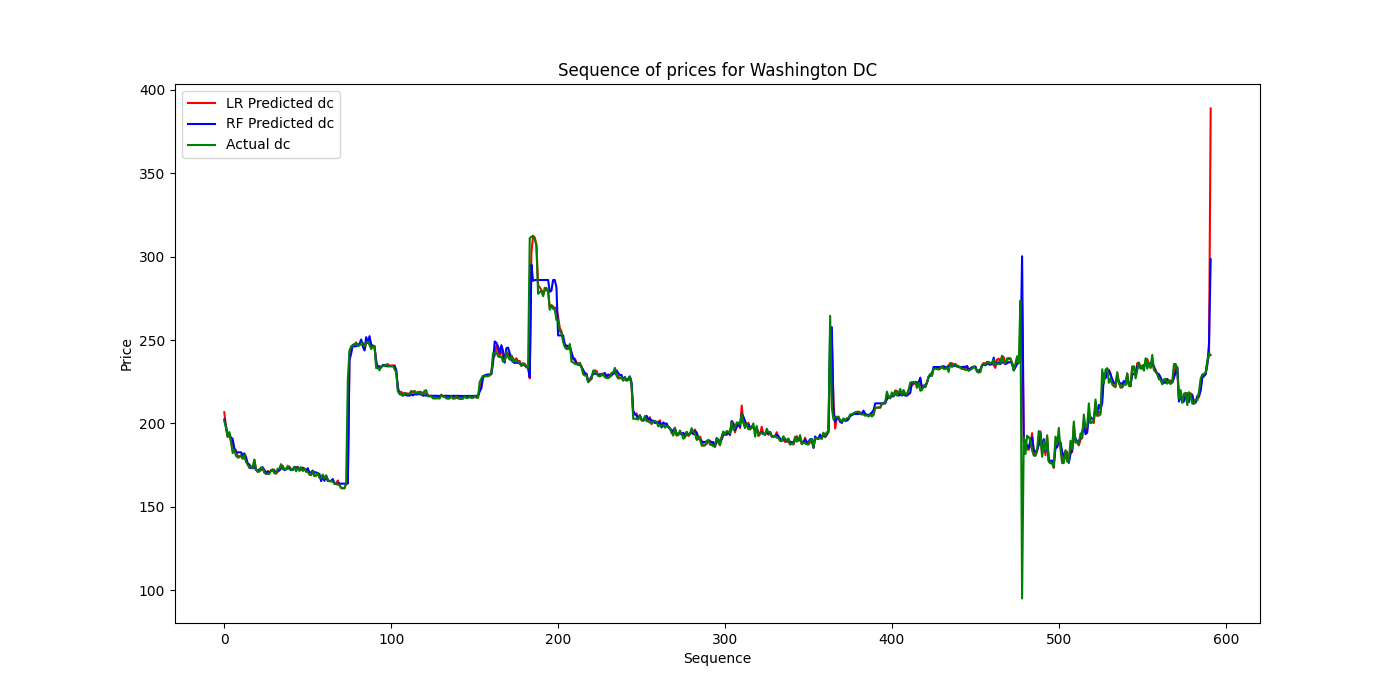

In [ ]:
plt.clf()
states = ['dc']
for state in states:
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_lr[state]['prediction'], 'r-', label=f'LR Predicted {state}')
    plt.plot(predictions_rf[state]['prediction'], 'b-', label=f'RF Predicted {state}')
    plt.plot(actuals[state]['avg_price'], 'g-', label=f'Actual {state}')
    plt.title(f'Sequence of prices for Washington DC')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend(loc='best')
%matplot plt

<center><i>Figure 12. Random Forest-Linear Regression Time Series Plot for Washington DC</i></center>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

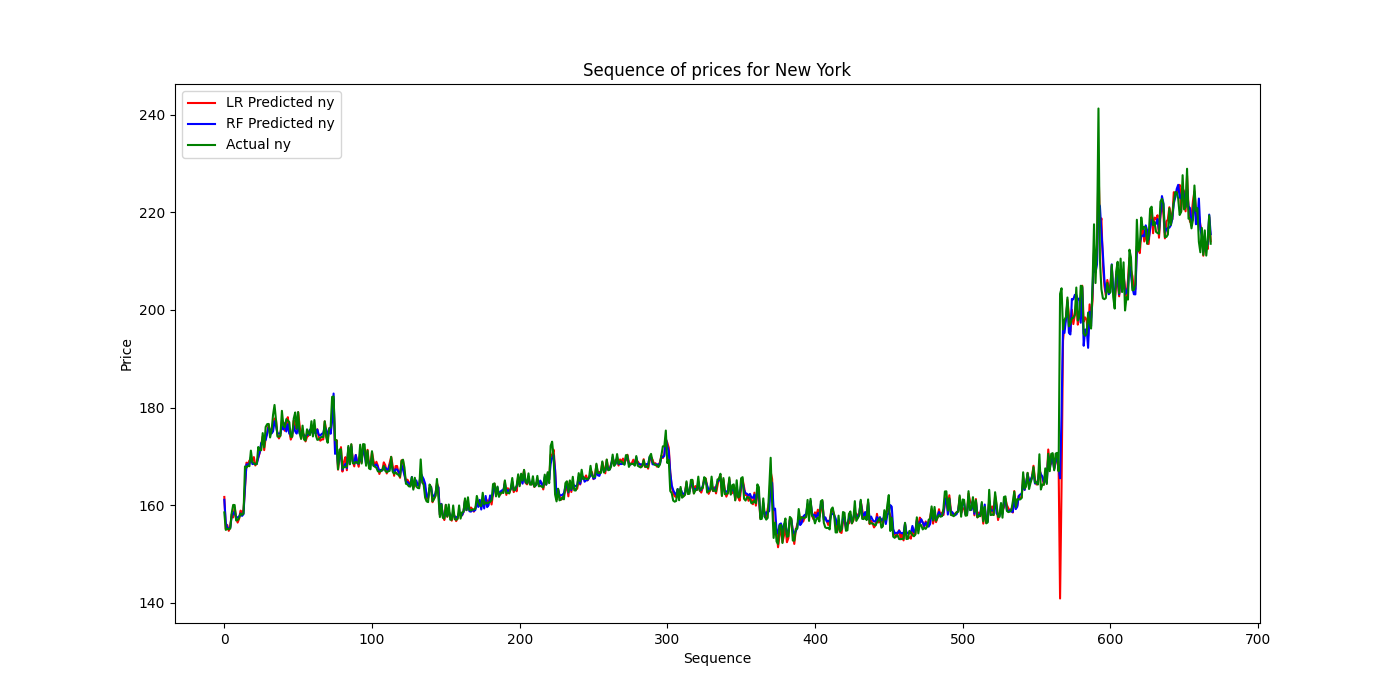

In [ ]:
plt.clf()
states = ['ny']
for state in states:
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_lr[state]['prediction'], 'r-', label=f'LR Predicted {state}')
    plt.plot(predictions_rf[state]['prediction'], 'b-', label=f'RF Predicted {state}')
    plt.plot(actuals[state]['avg_price'], 'g-', label=f'Actual {state}')
    plt.title(f'Sequence of prices for New York')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend(loc='best')
%matplot plt

<center><i>Figure 13. Random Forest-Linear Regression Time Series Plot for New York</i></center>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

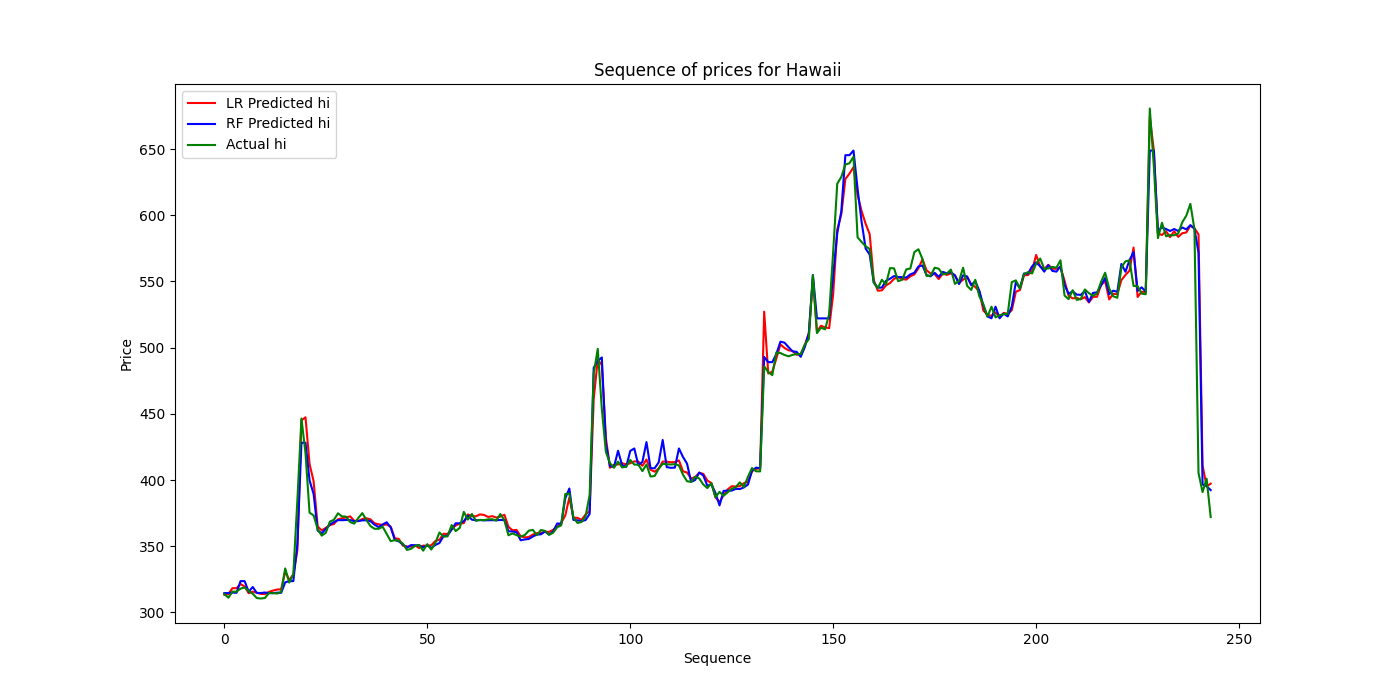

In [ ]:
plt.clf()
states = ['hi']
for state in states:
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_lr[state]['prediction'], 'r-', label=f'LR Predicted {state}')
    plt.plot(predictions_rf[state]['prediction'], 'b-', label=f'RF Predicted {state}')
    plt.plot(actuals[state]['avg_price'], 'g-', label=f'Actual {state}')
    plt.title(f'Sequence of prices for Hawaii')
    plt.xlabel('Sequence')
    plt.ylabel('Price')
    plt.legend(loc='best')
%matplot plt

<center><i>Figure 14. Random Forest-Linear Regression Time Series Plot for Hawaii</i></center>

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id, abs, col

performance_lr = {}
performance_rf = {}

for state in states:
    # Linear Regression
    pred_lr = predictions_lr[state]
    pred_lr = spark.createDataFrame(pred_lr)
    actual_lr = actuals[state]
    actual_lr = spark.createDataFrame(actual_lr)

    pred_lr = pred_lr.withColumn("id", monotonically_increasing_id())
    actual_lr = actual_lr.withColumn("id", monotonically_increasing_id())
    pred_lr = pred_lr.join(actual_lr, "id", "outer").drop("id")

    evaluator_rmse_lr = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="rmse")
    rmse_lr = evaluator_rmse_lr.evaluate(pred_lr)

    evaluator_mse_lr = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mse")
    mse_lr = evaluator_mse_lr.evaluate(pred_lr)

    evaluator_mae_lr = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mae")
    mae_lr = evaluator_mae_lr.evaluate(pred_lr)

    mape_lr = pred_lr.withColumn('MAPE', (abs((col('avg_price') - col('prediction')) / col('avg_price')) * 100)).select('MAPE').agg({'MAPE': 'mean'}).collect()[0][0]

    performance_lr[state] = {'RMSE': rmse_lr, 'MSE': mse_lr, 'MAE': mae_lr, 'MAPE': mape_lr}

    # Random Forest Regression
    pred_rf = predictions_rf[state]
    pred_rf = spark.createDataFrame(pred_rf)
    actual_rf = actuals[state]
    actual_rf = spark.createDataFrame(actual_rf)

    pred_rf = pred_rf.withColumn("id", monotonically_increasing_id())
    actual_rf = actual_rf.withColumn("id", monotonically_increasing_id())
    pred_rf = pred_rf.join(actual_rf, "id", "outer").drop("id")

    evaluator_rmse_rf = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="rmse")
    rmse_rf = evaluator_rmse_rf.evaluate(pred_rf)

    evaluator_mse_rf = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mse")
    mse_rf = evaluator_mse_rf.evaluate(pred_rf)

    evaluator_mae_rf = RegressionEvaluator(predictionCol="prediction", labelCol="avg_price", metricName="mae")
    mae_rf = evaluator_mae_rf.evaluate(pred_rf)

    mape_rf = pred_rf.withColumn('MAPE', (abs((col('avg_price') - col('prediction')) / col('avg_price')) * 100)).select('MAPE').agg({'MAPE': 'mean'}).collect()[0][0]

    performance_rf[state] = {'RMSE': rmse_rf, 'MSE': mse_rf, 'MAE': mae_rf, 'MAPE': mape_rf}

# Print performance metrics
for state in states:
    print(f"Performance for {state} (Linear Regression):")
    print(f"RMSE: {performance_lr[state]['RMSE']}")
    print(f"MSE: {performance_lr[state]['MSE']}")
    print(f"MAE: {performance_lr[state]['MAE']}")
    print(f"MAPE: {performance_lr[state]['MAPE']}")
    print("-----------------------------")

    print(f"Performance for {state} (Random Forest Regression):")
    print(f"RMSE: {performance_rf[state]['RMSE']}")
    print(f"MSE: {performance_rf[state]['MSE']}")
    print(f"MAE: {performance_rf[state]['MAE']}")
    print(f"MAPE: {performance_rf[state]['MAPE']}")
    print("-----------------------------")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Performance for co (Linear Regression):
RMSE: 3.5285914770845297
MSE: 12.450957812153582
MAE: 2.5463093705404503
MAPE: 1.4382263359933418
-----------------------------
Performance for co (Random Forest Regression):
RMSE: 3.6974629730967643
MSE: 13.671232437421564
MAE: 2.4503285874893437
MAPE: 1.3774833653754752
-----------------------------
Performance for ca (Linear Regression):
RMSE: 4.312859637574617
MSE: 18.60075825342026
MAE: 2.538040744257579
MAPE: 1.026416445970983
-----------------------------
Performance for ca (Random Forest Regression):
RMSE: 4.825453391040299
MSE: 23.285000429102325
MAE: 2.705678981477841
MAPE: 1.0693683865441719
-----------------------------
Performance for dc (Linear Regression):
RMSE: 10.865267336882749
MSE: 118.05403430193114
MAE: 2.2249042140329953
MAPE: 1.1758891919828747
-----------------------------
Performance for dc (Random Forest Regression):
RMSE: 10.668848938664382
MSE: 113.82433767604013
MAE: 2.8988680140453353
MAPE: 1.4951137692237015
-------

<h1 style="color:#000000">VIII. Result</h1>

With the notable increase in listing prices due to the pandemic, we expected fairly high errors due to the time series being non-stationary. But despite non-stationarity, we were able to obtain a MAPE as low as 1.14% which we believe is due to the choice of look-back window. This means that looking at the past seven days is enough for our model to make an accurate price prediction for the next day despite going through market changes brought about by the pandemic.

<h1 style="color:#000000">IX. Conclusion</h1>

Our project demonstrates the immense value of time series analysis in empowering Airbnb hosts in top US tourist destinations to make more informed pricing decisions. By accurately predicting market price trends, we provide hosts with valuable insights into the shifting demand patterns over time. This is particularly beneficial for hosts who may not have extensive knowledge of market dynamics. Additionally, our predictions enable customers to plan and budget ahead of time, considering potential price changes that may occur. By bridging the gap between hosts and customers, our project enhances the overall Airbnb experience and fosters a more efficient and transparent marketplace.

<h1 style="color:#000000">X. Recommendation</h1>

Forecast for Multiple Countries: Airbnb operates globally and each market is distinct due to various factors like cultural differences, economic conditions and tourism appeal. It would be beneficial to extend our forecasting models to cover other countries, which will not only increase the breadth of our analysis but also allow us to make comparisons and understand market dynamics at a global scale.

Use NLP to Extract More Insights from Data: Our dataset contains rich textual data in the form of reviews. Natural Language Processing (NLP) can be used to analyze these reviews for sentiment, which can provide additional insights into guest experiences and the factors that contribute to a successful listing. Through sentiment analysis, NLP can help identify common themes in positive and negative reviews or even predict ratings based on review content.

Try Out Other Models: While our current forecasting models have been effective, there may be other models that can provide more accurate or meaningful results. Experimenting with other types of models such as time series analysis models (ARIMA, SARIMA) among others could lead to improvements in our forecasting ability.

Make Our Methods More Scalable: Our current data processing and exploration approach was rather resource-intensive and might not scale well with larger coverage on the dataset. It would be beneficial to invest in data pipeline automation, efficient data storage solutions and more scalable machine learning models. This will ensure that as we expand our analysis to other markets, our infrastructure can handle the increased data volume and complexity.